In [1]:
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_addons as tfa
import cv2
from skimage import io, color
from tensorflow.data import AUTOTUNE

import time

from IPython import display

%matplotlib inline

In [2]:
tf.__version__

'2.10.1'

In [3]:
# data path 

face_path = r"D:\data\cartoonset10k"

In [4]:
images = os.listdir(path=face_path)
images = [os.path.join(face_path, image) for image in images if image.endswith(".png")]
len(images)

10000

In [5]:
list_ds = tf.data.Dataset.list_files(images, shuffle=False)
list_ds = list_ds.shuffle(len(images),reshuffle_each_iteration=False)

In [6]:
for f in list_ds.take(5):
    print(f.numpy())

b'D:\\data\\cartoonset10k\\cs11248583200868356810.png'
b'D:\\data\\cartoonset10k\\cs10976919090923670139.png'
b'D:\\data\\cartoonset10k\\cs11241575768645678362.png'
b'D:\\data\\cartoonset10k\\cs10561508776164454103.png'
b'D:\\data\\cartoonset10k\\cs10131630302773482018.png'


In [7]:
image_count = len(images)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [8]:
width = 128
height = 128

In [9]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img1 = tf.io.decode_jpeg(img, channels=3)
  img1 = tf.image.resize(img1, [width, height])
  img1 = tf.cast(img1, tf.float32) / 255.
  
  img3 = tfio.experimental.color.rgb_to_lab(img1)
  img2 = tf.image.rgb_to_grayscale(img1)
  return img2, img3[:,:,1:]

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img2, img3 = decode_img(img)
  return img2, img3


train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(16)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

0.99990004
0.99990004
0.99990004
0.99990004


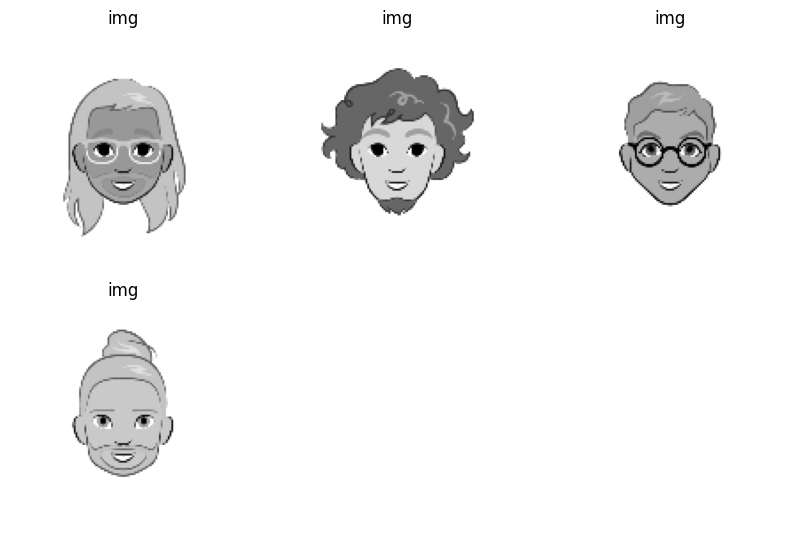

In [11]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy() 
  print(img.max())
  # img *= 255
  # i = i.astype("uint8")
  plt.imshow(img, cmap='gray')
#   label = label_batch[i]
  plt.title("img")
  plt.axis("off")

1.0
1.0
0.99990004
1.0


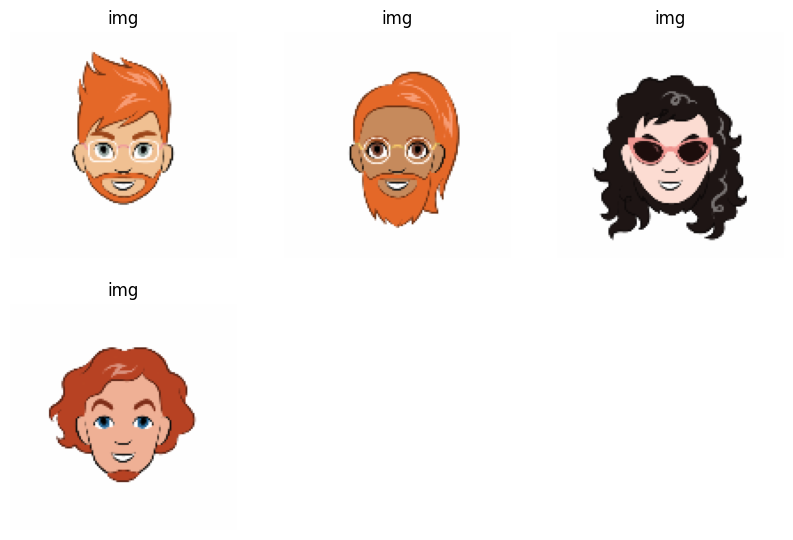

In [12]:
image_batch1, image_batch2 = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(3, 3, i + 1)
  imgL = color.rgb2lab(color.gray2rgb(image_batch1[i].numpy()[:,:,0]))[:,:,0]
  img = image_batch2[i].numpy()
  img = np.dstack((imgL, img))
  img = color.lab2rgb(img)
  print(img.max())
  # img *= 255
  # i = i.astype("uint8")
  plt.imshow(img)
#   label = label_batch[i]
  plt.title("img")
  plt.axis("off")

In [13]:
image_batch[0].shape, image_batch2[0].shape

(TensorShape([128, 128, 1]), TensorShape([128, 128, 2]))

In [14]:
# Build A DC GAN model 

In [15]:
# Build encoder decoder model using keras functional API

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(128, 128, 1)))
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(2, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    return model

generator = make_generator_model()
generator.summary()


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# Discriminator loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,out_images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(images, training=True)

      real_output = discriminator(out_images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
import time

def generate_and_save_images(model, epoch, img_1, img2):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(img_1, training=False)

  fig = plt.figure(figsize=(80, 80))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      imgL = color.rgb2lab( color.gray2rgb(img_1[i].numpy()[:,:,0]))[:,:,:1]
      # print(imgL.shape,predictions[i].shape)
      img =  np.dstack((imgL,predictions[i]))
      img = color.lab2rgb(img)
      plt.imshow(img) # * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for img1,img2 in dataset:
      # img1 = tf.cast(img1, tf.float32)
      # img2 = tf.cast(img2, tf.float32)
      train_step(img1,img2)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             img1,img2)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           img1,img2)

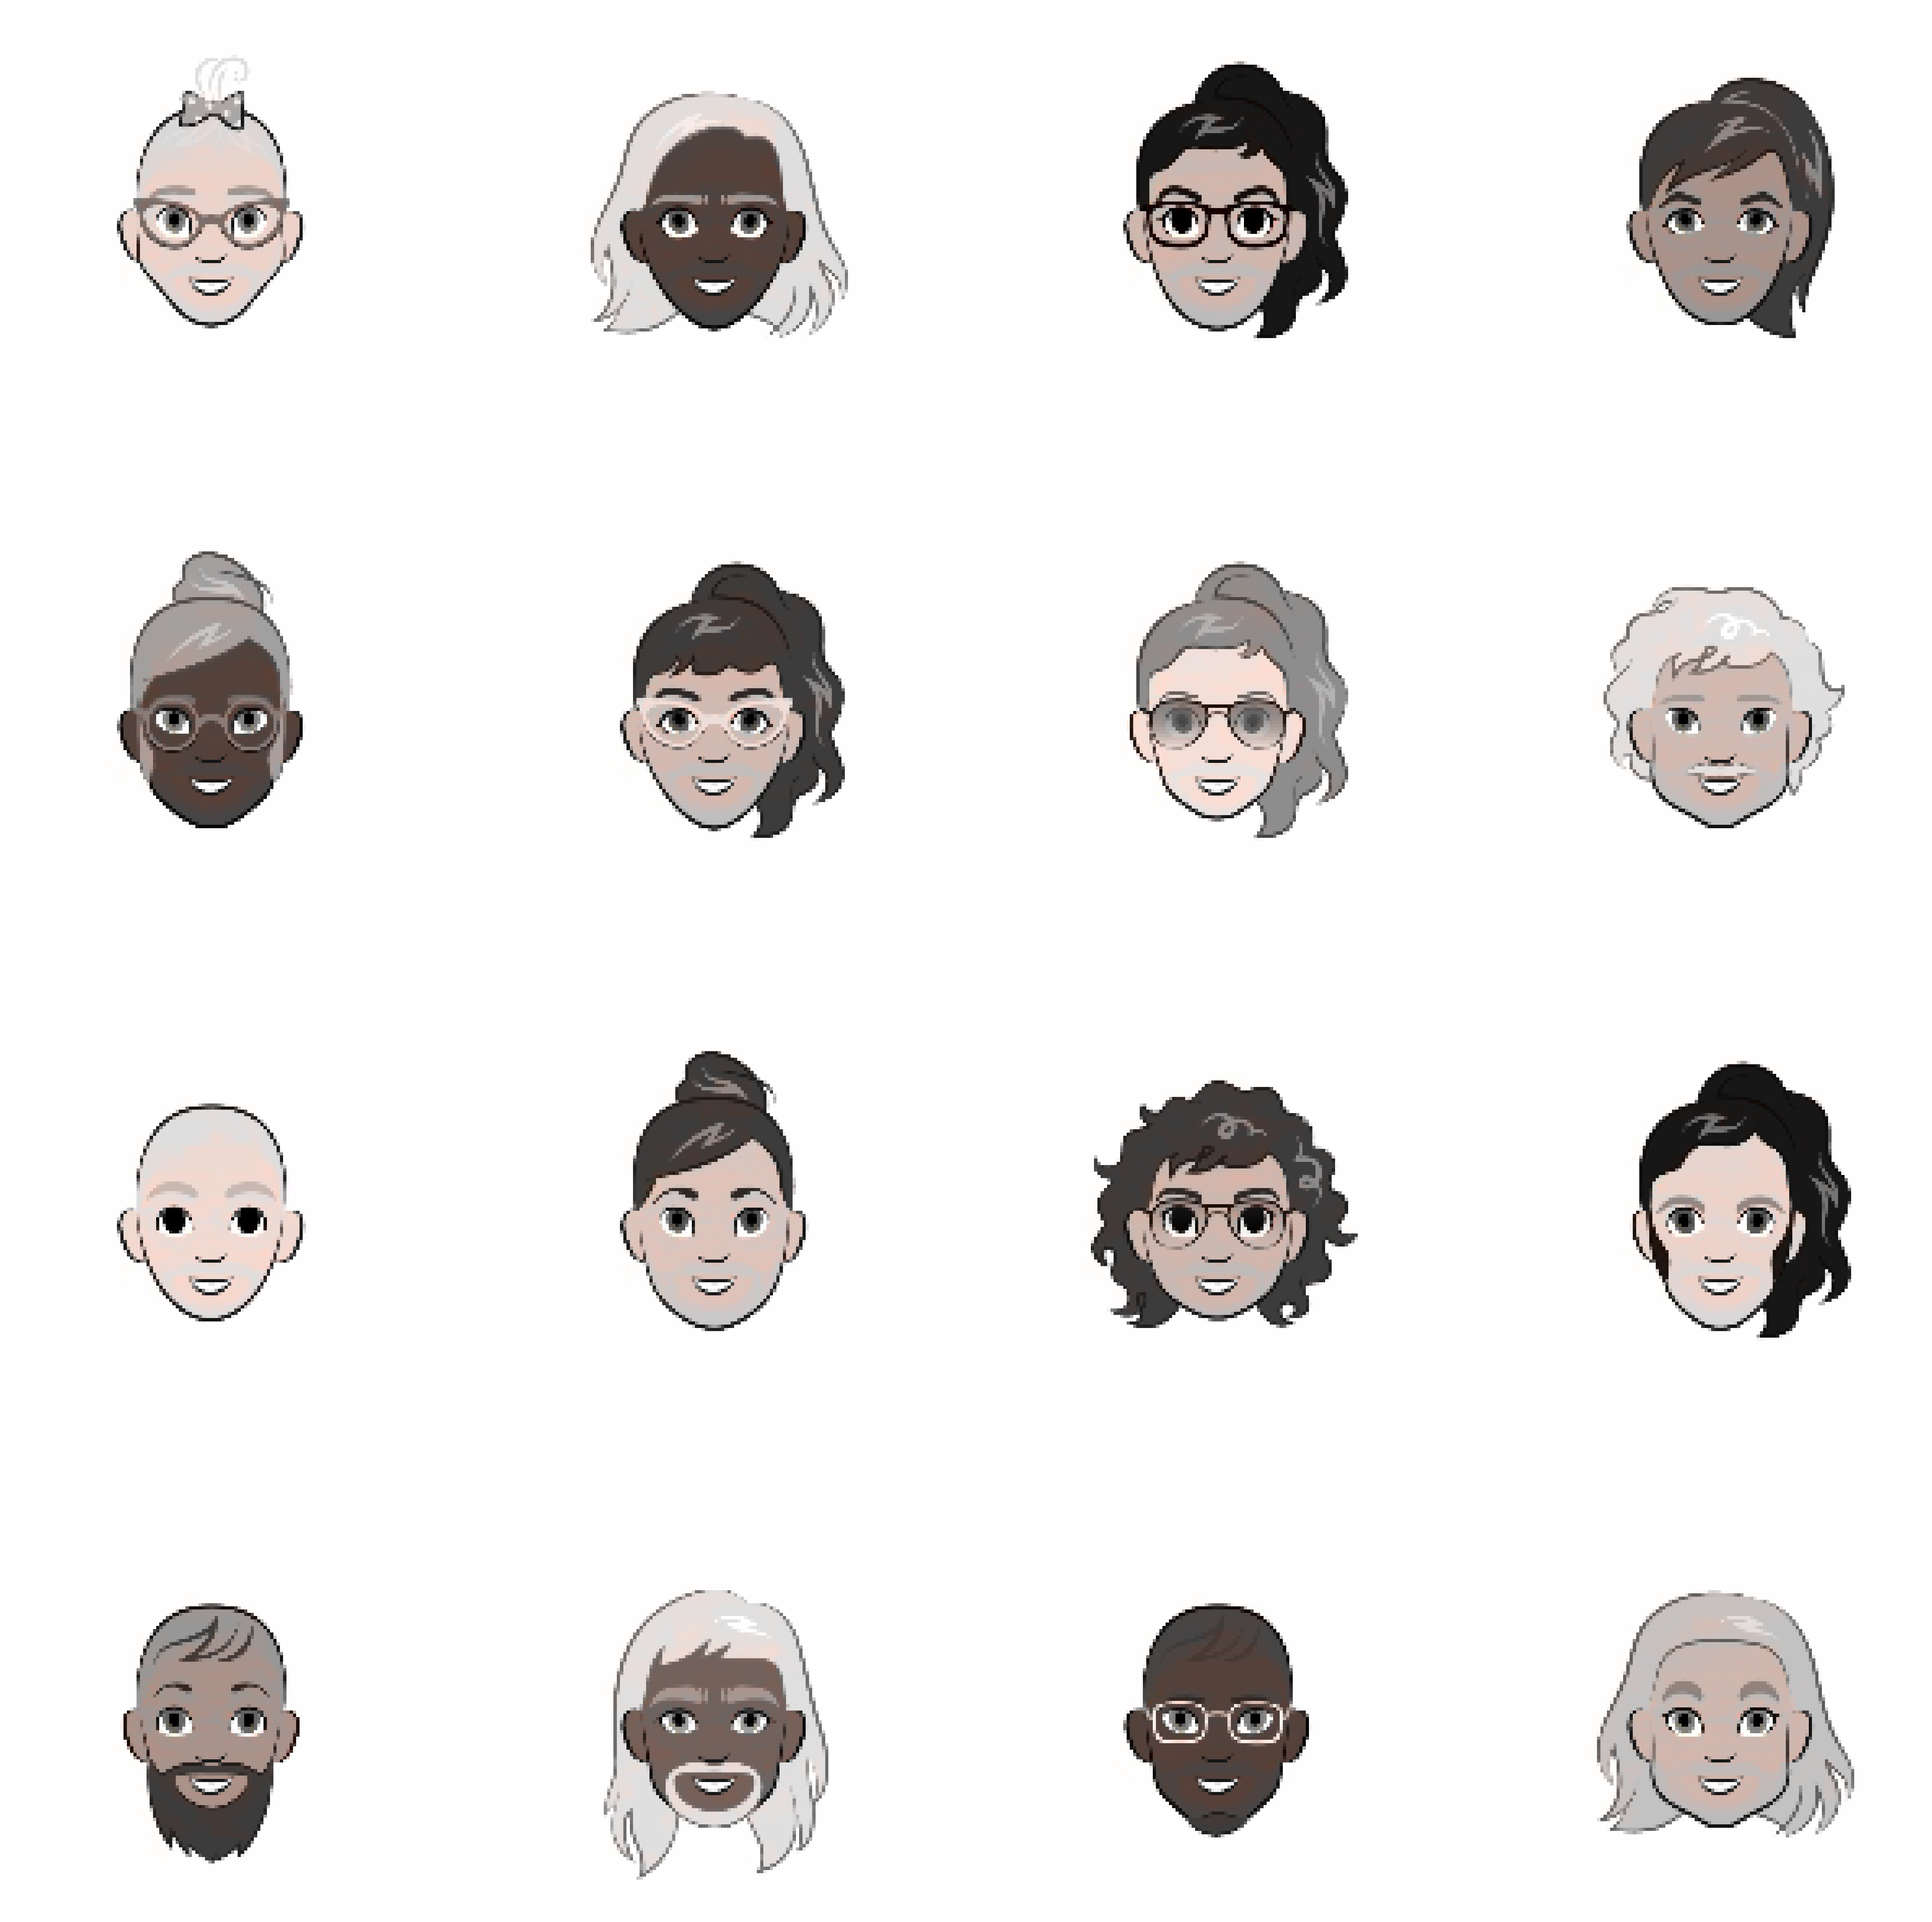

In [22]:
train(train_ds, 20)

In [29]:
generator.save("D:/models/cartoon_generator")
discriminator.save("D:/models/cartoon_discriminator")

INFO:tensorflow:Assets written to: D:/models/cartoon_generator\assets


INFO:tensorflow:Assets written to: D:/models/cartoon_generator\assets


INFO:tensorflow:Assets written to: D:/models/cartoon_discriminator\assets


INFO:tensorflow:Assets written to: D:/models/cartoon_discriminator\assets


In [30]:
i1 ,i2 =next(iter(val_ds))

In [31]:
i1.shape

TensorShape([16, 128, 128, 1])

In [32]:
color.rgb2lab( color.gray2rgb(i1[i].numpy()[:,:,0]))[:,:,:1].shape

(128, 128, 1)

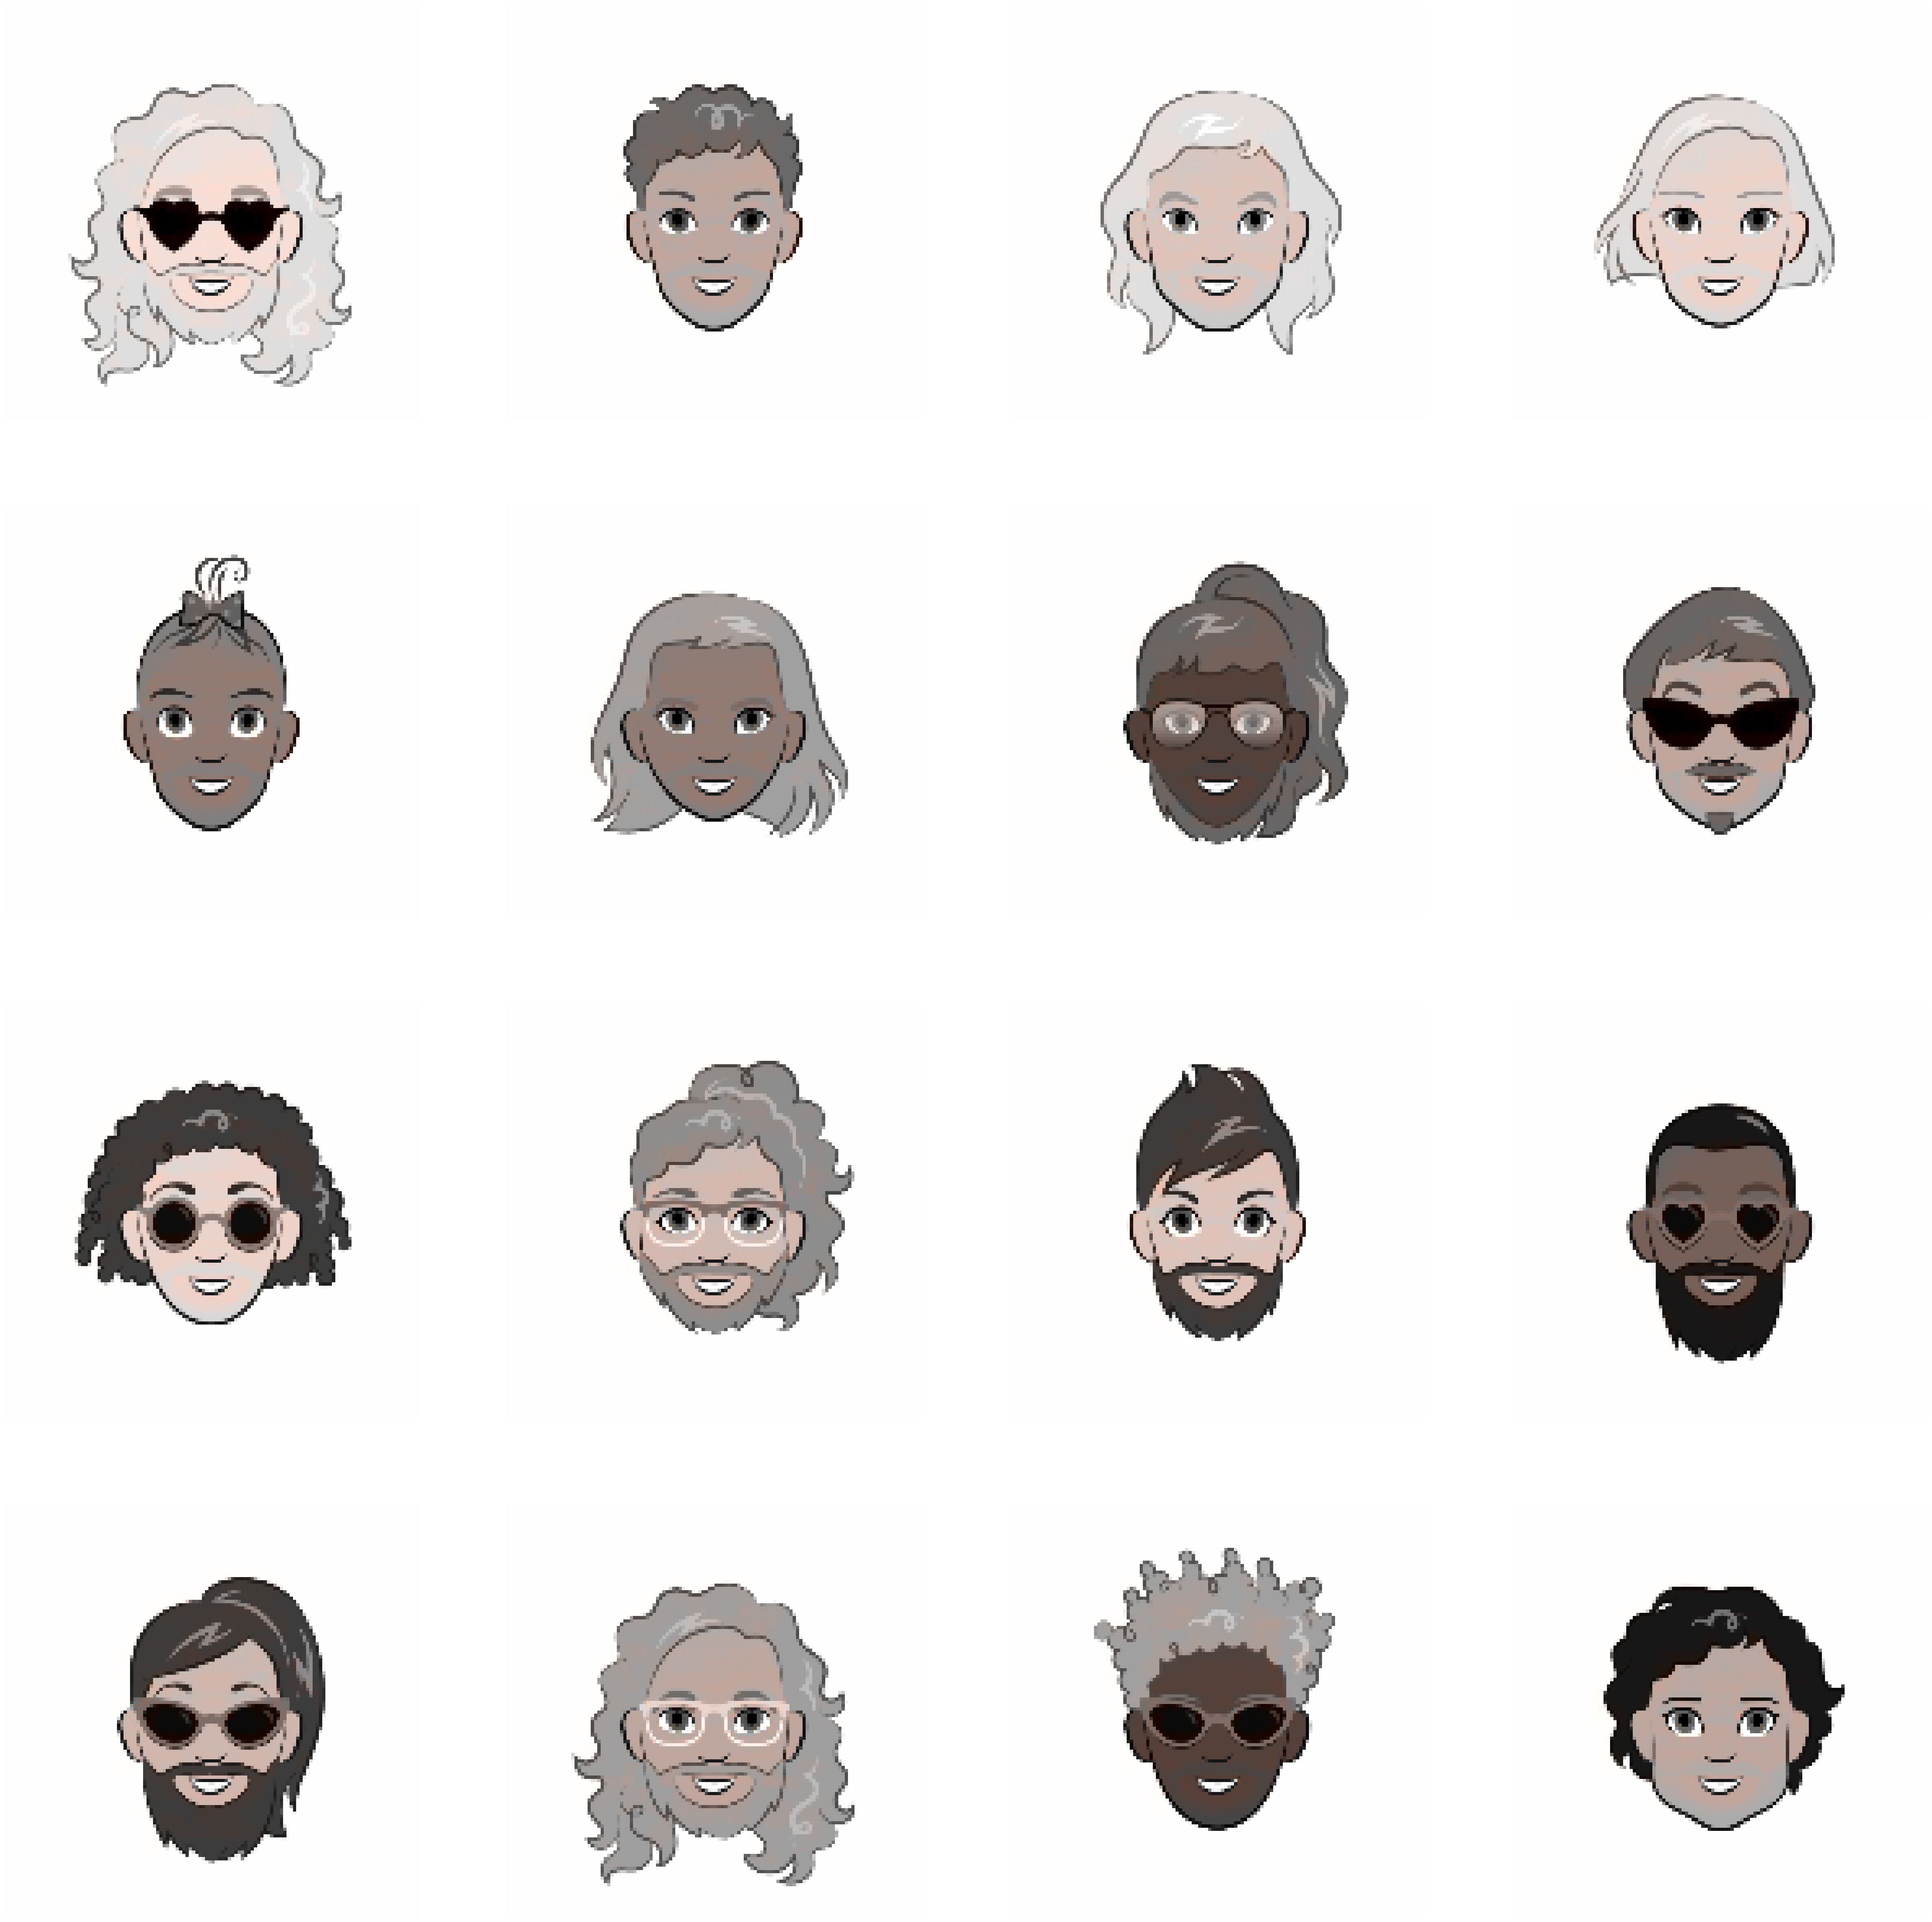

In [33]:
generate_and_save_images(generator,1,i1,i2)

In [27]:
output = generator(i1, training = False)
print(output.shape)

(16, 128, 128, 2)


In [49]:
# test with sample image 
face_path = "D:/data/faces/obama.jpg"

img = tf.io.decode_jpeg(tf.io.read_file(face_path), channels=1)
img = tf.image.resize(img, [128, 128])
img = tf.cast(img, tf.float32) / 255. # normalize to [0,1] range
img = tfa.image.gaussian_filter2d(img, [5,5])

img = tf.expand_dims(img, 0) # Create a batch

In [50]:
out = generator(img, training = False)
out.shape

TensorShape([1, 128, 128, 2])

In [51]:
imgL = color.rgb2lab( color.gray2rgb(img[0].numpy()[:,:,0]))[:,:,:1]
# print(imgL.shape,predictions[i].shape)
imgout =  np.dstack((imgL,out[0]))
imgout = color.lab2rgb(imgout)

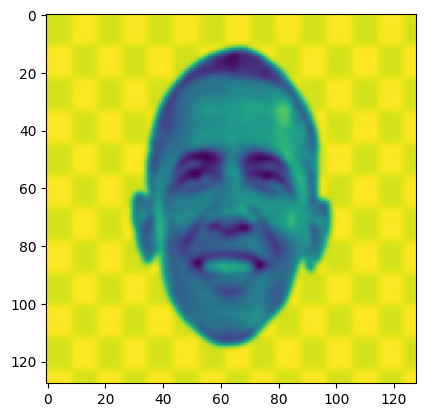

: 

In [52]:
plt.imshow(imgL)

In [ ]:


lab2color = color.lab2rgb(i2[0])

plt.imshow(lab2color)